In [1]:
import glob
import json
from jammato.dicom_reader import Dicom_Reader
from data_cleaning import data_cleaning_instance
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2
from os.path import exists
from sklearn.model_selection import train_test_split
from collections import defaultdict
import sys

In [2]:
def attributes_to_dict(all_sequences, dicom_series, file_name):
    try:
        contrast_type = dicom_series.__dict__["seriesDescription"]
        study_id = dicom_series.__dict__["studyInstanceUid"]
        series_id = dicom_series.__dict__["seriesInstanceUid"]
        echo_time = dicom_series.__dict__["effectiveEchoTime"]
        repetition_time = dicom_series.__dict__["repetitionTime"]
        patient_name = dicom_series.__dict__["patientsName"]
        magnetic_field_strength = dicom_series.__dict__["magneticFieldStrength"]
        mr_acquisition_type = dicom_series.__dict__["mrAcquisitionType"]
        # sequence_name=dicom_series.__dict__["sequenceName"]
        flip_angle = dicom_series.__dict__["flipAngle"]
        # slice_location=dicom_series.__dict__["sliceLocation"]
        image_position_patient = str(
            dicom_series.__dict__["imagePositionpatient"]
        )  ## since it is a list, convert to a string

        all_sequences["fileName"].append(file_name)
        all_sequences["studyInstanceUid"].append(study_id)
        all_sequences["seriesInstanceUid"].append(series_id)
        all_sequences["contrast"].append(contrast_type)
        all_sequences["effectiveEchoTime"].append(echo_time)
        all_sequences["repetitionTime"].append(repetition_time)
        all_sequences["patientsName"].append(patient_name)
        all_sequences["magneticFieldStrength"].append(magnetic_field_strength)
        all_sequences["mrAcquisitionType"].append(mr_acquisition_type)
        # all_sequences["sequenceName"].append(sequence_name)
        all_sequences["flipAngle"].append(flip_angle)
        # all_sequences["sliceLocation"].append(slice_location)
        all_sequences["imagePositionpatient"].append(image_position_patient)
    except KeyError as e:
        print(f"missing attribute: {e} in {file_name}")

    return all_sequences

In [3]:
def get_objects(file_path):
    pixel_arrays = {}
    all_dicom_objects = {}
    for file in file_path:
        file_name = '/'.join(file.split("/")[-2:])
        dicom_series = Dicom_Reader(file)
        sub_dict = Dicom_Reader.pydicom_object_search(dicom_series.pydicom_file)
        data_cleaning_instance.load_attributes(sub_dict)
        data_cleaning_instance.set_attributes_from_config()
        dicom_series.__dict__.update(data_cleaning_instance.attributes_dict)
        pixel_arrays[file_name] = dicom_series.pydicom_file.pixel_array
        del dicom_series.pydicom_file
        del dicom_series.pixelData
        all_dicom_objects[file_name] = dicom_series
    return all_dicom_objects, pixel_arrays

In [4]:
if (exists("mri_imt_cuso.p")) and (exists("mri_imt_cuso2.p")) == False:
    files_cuso = glob.glob("/hkfs/work/workspace_haic/scratch/bg4112-mriml/data/CuSO4_dataset/*")
    files_cuso2 = glob.glob("/hkfs/work/workspace_haic/scratch/bg4112-mriml/data/CuSO4_dataset_2/All_dicom/*")

    ####Possibly interesting is: studyDateTime, imagingFrequency, echoNumbers, contrastbolusVolume, seriesNumber, instanceNumber, imagePositionpatient, numberOfFrames, smallestImagePixelValue, largestImagePixelValue

    mri_imt_cuso, mri_int_pixel_arrays_cuso = get_objects(files_cuso)
    mri_imt_cuso2, mri_int_pixel_arrays_cuso2 = get_objects(files_cuso2)
    pickle.dump(mri_imt_cuso, open("mri_imt_cuso.p", "wb"))
    pickle.dump(mri_int_pixel_arrays_cuso, open("mri_imt_cuso_pixel_arrays.p", "wb"))
    pickle.dump(mri_imt_cuso2, open("mri_imt_cuso2.p", "wb"))
    pickle.dump(mri_int_pixel_arrays_cuso2, open("mri_imt_cuso_pixel_arrays2.p", "wb"))
else:
    mri_imt_cuso = pickle.load(open("mri_imt_cuso.p", "rb"))
    mri_int_pixel_arrays_cuso = pickle.load(open("mri_imt_cuso_pixel_arrays.p", "rb"))
    mri_imt_cuso2 = pickle.load(open("mri_imt_cuso2.p", "rb"))
    mri_int_pixel_arrays_cuso2 = pickle.load(open("mri_imt_cuso_pixel_arrays2.p", "rb"))
    
all_sequences = {
    "fileName": [],
    "studyInstanceUid": [],
    "seriesInstanceUid": [],
    "contrast": [],
    "mrAcquisitionType": [],
    "effectiveEchoTime": [],
    "flipAngle": [],
    "repetitionTime": [],
    "patientsName": [],
    "magneticFieldStrength": [],
    "imagePositionpatient": [],
}
#all_sequences_empty = all_sequences.copy()
#all_sequences_empty2 = all_sequences.copy()

for key_cuso, value_cuso in mri_imt_cuso.items():
    all_sequences_cuso = attributes_to_dict(all_sequences, value_cuso, key_cuso)
    
for key_cuso, value_cuso in mri_imt_cuso2.items():
    all_sequences_cuso2 = attributes_to_dict(all_sequences_cuso, value_cuso, key_cuso)

#adding second dataset
mri_imt_cuso.update(mri_imt_cuso2)
mri_int_pixel_arrays_cuso.update(mri_int_pixel_arrays_cuso2)

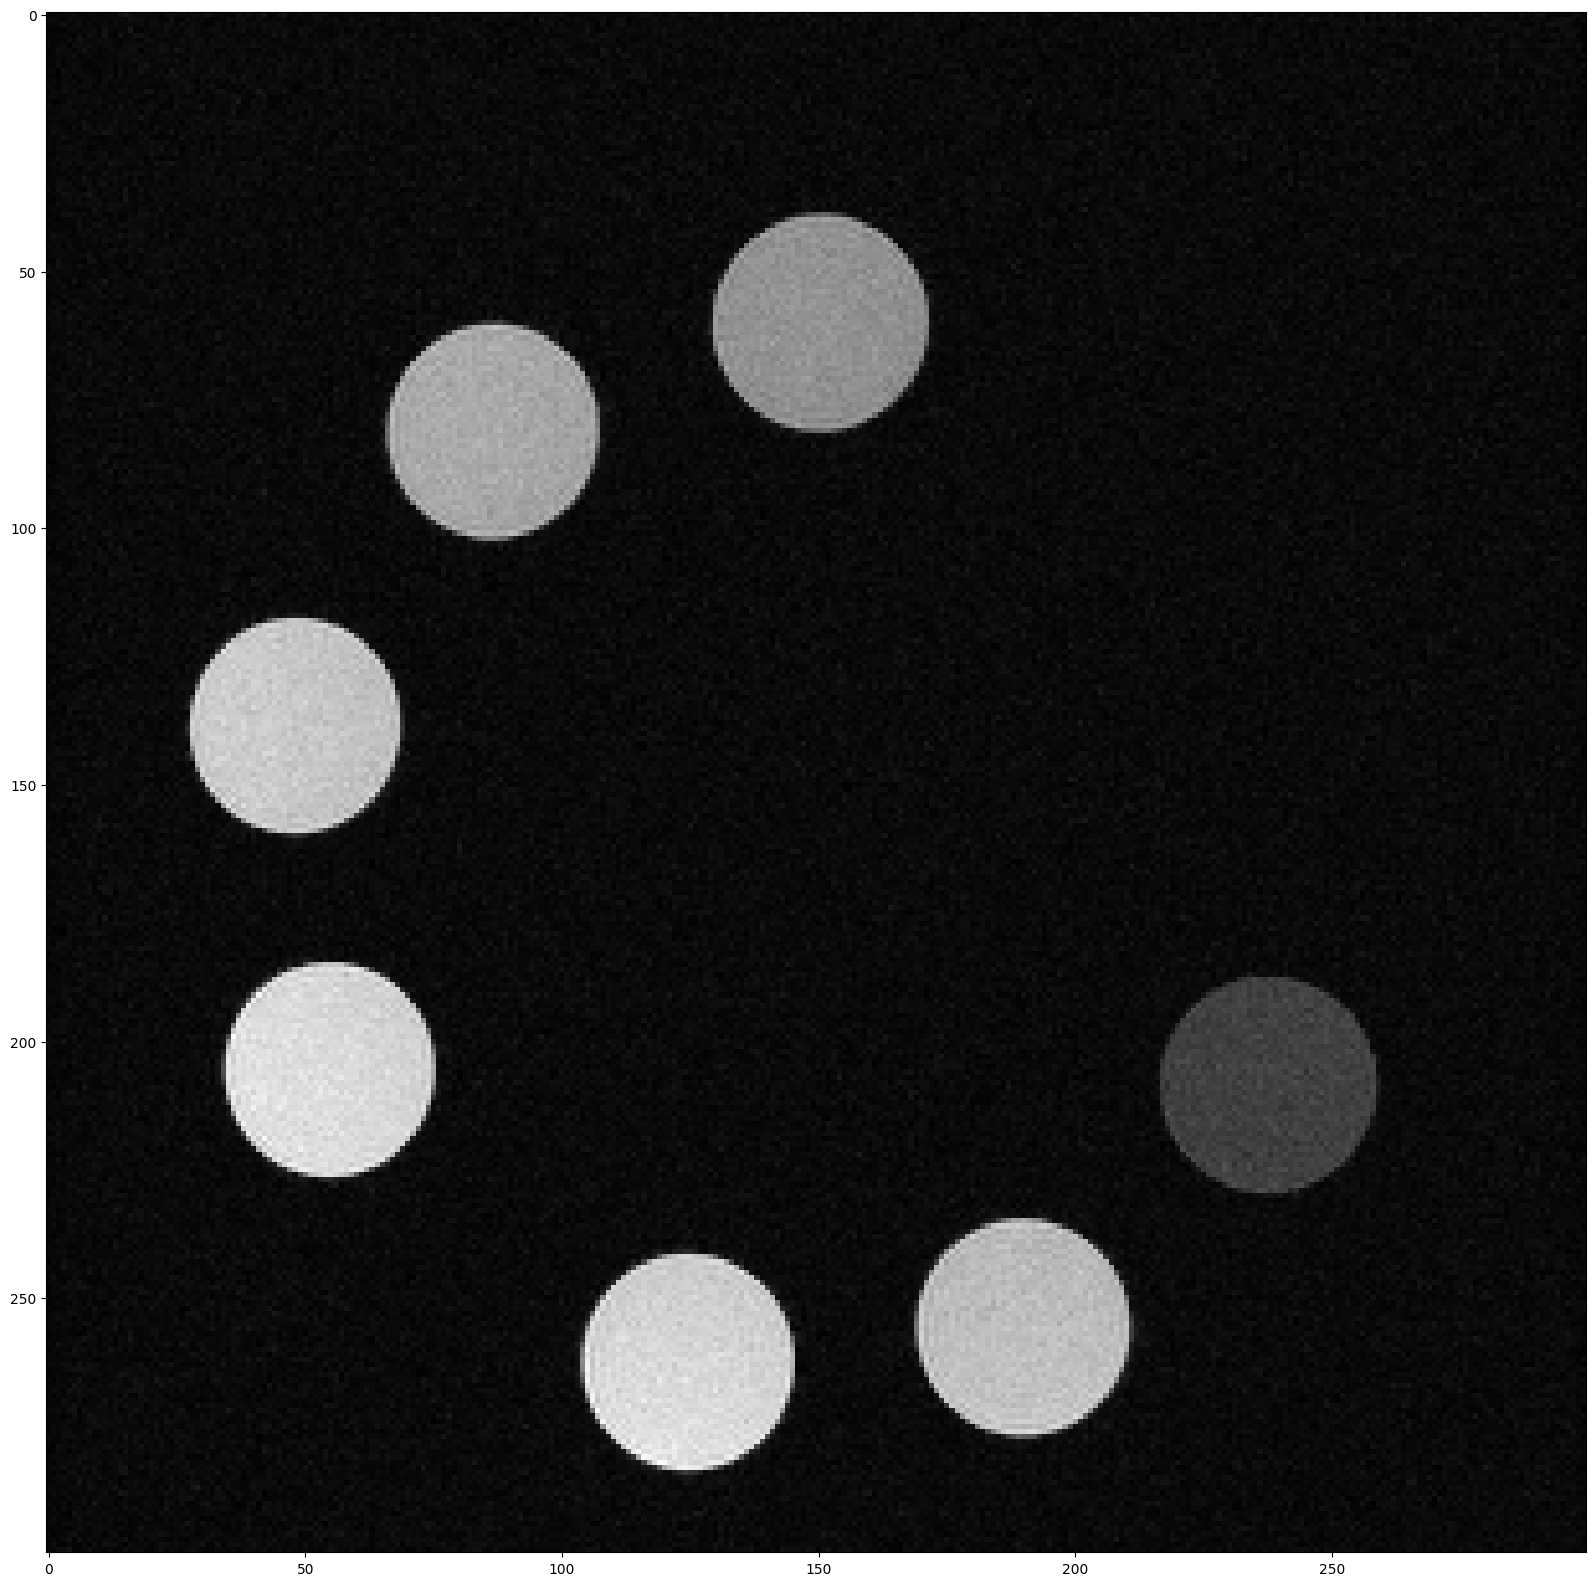

In [11]:
plt.figure(figsize=(20, 20))
plt.imshow(mri_int_pixel_arrays_cuso['CuSO4_dataset/series1.dcm'][1].squeeze(), cmap="gray")

In [6]:
def ingest_data(names_dataset: list, names_pixel_array: list, paths: list):

    updated_dataset={}
    updated_pixel_array={}
    all_sequences = {
            "fileName": [],
            "studyInstanceUid": [],
            "seriesInstanceUid": [],
            "contrast": [],
            "mrAcquisitionType": [],
            "effectiveEchoTime": [],
            "flipAngle": [],
            "repetitionTime": [],
            "patientsName": [],
            "magneticFieldStrength": [],
            "imagePositionpatient": [],
        }
    
    for name_dataset, name_pixel_array, path in zip(names_dataset, names_pixel_array, paths):
        if (exists(name_dataset)) and (exists(name_pixel_array)) == False:
            file=glob.glob(path+"/*")
            dataset, pixel_array = get_objects(file)
            pickle.dump(dataset, open(name_dataset, "wb"))
            pickle.dump(pixel_array, open(name_pixel_array, "wb"))
        else:
            dataset=pickle.load(open(name_dataset, "rb"))
            pixel_array=pickle.load(open(name_pixel_array, "rb"))

        
        for key, value in dataset.items():
            all_sequences = attributes_to_dict(all_sequences, value, key)

        all_sequences2 = all_sequences.copy()
        updated_dataset.update(dataset)
        updated_pixel_array.update(pixel_array)
        
    return updated_dataset, updated_pixel_array, all_sequences

In [7]:
def index_dicts(dictionary):
    patientsName_ref = None
    all_file_names = {}
    all_metadata = []
    for value in dictionary.values():
        patientsName = value.__dict__["studyDescription"]
        if patientsName_ref == None:
            patientsName_ref = patientsName
        if patientsName_ref == patientsName:
            all_metadata.append(value.__dict__)
        elif patientsName_ref != patientsName:
            all_file_names[patientsName_ref] = all_metadata
            patientsName_ref = patientsName
            all_metadata = []
            all_metadata.append(value.__dict__)
        else:
            pass
    all_file_names[patientsName_ref] = all_metadata
    return all_file_names


In [8]:
def compare_lists(lists):
    """Returns True if all input lists have identical elements, False otherwise."""
    if not lists:
        return False
    first_list = lists[0]
    for i in range(1, len(lists)):
        if len(first_list) != len(lists[i]):
            return False
        else:
            pass
        state = True
        for x, y in zip(first_list, lists[i]):
            state = x == y
            if state == False:
                return False
            else:
                pass
        # if not all(str(x) == str(y) for x, y in zip(first_list, lists[i])):
        #    return False
    return True

In [9]:
def common_keys(dict_list):
    try:
        """Returns a dictionary containing the keys common in all input dictionaries and their values,
        but only for keys where the values are different."""
        # Find the set of keys common to all input dictionaries
        common_keys = set.intersection(*map(set, dict_list))

        # Create a dictionary with the common keys and their values in each input dictionary
        result = {}
        for key in common_keys:
            temp = []
            for d in dict_list:
                if key in d:
                    temp.append(d[key])
                # values = [d[key] for d in dicts]
                else:
                    pass
            try:
                if (len(temp) > 1) and (len(list(set(temp))) > 1):
                    result[key] = temp
            except TypeError:
                if (len(temp) > 1) and (compare_lists(temp) == False):
                    result[key] = temp
        return result
    except TypeError:
        return {"None": "None"}


In [10]:
def metadata_deviations(all_file_names):
    all_attributes = {}
    example_of_attributes = {}
    for key in list(all_file_names.keys()):
        metadata_diffs = common_keys(all_file_names[key])
        metadata_diffs_keys = list(metadata_diffs.keys())
        for key in metadata_diffs_keys:
            example_of_attributes[key] = metadata_diffs[key]
            if key in all_attributes:
                all_attributes[key] += 1
            else:
                all_attributes[key] = 1
    all_attributes
    all_keys = []
    all_studies = []
    for key, value in all_attributes.items():
        all_keys.append(key)
        all_studies.append(value)
    return all_attributes, all_keys, all_studies, example_of_attributes


In [11]:
def list_duplicates(seq):
    tally = defaultdict(list)
    for i, item in enumerate(seq):
        tally[item].append(i)
    '''return ((key,locs) for key,locs in tally.items() 
                            if len(locs)>1)'''
    return ((locs) for key, locs in tally.items() if len(locs) > 1)

In [12]:
def image_cropping(image, name, cropping_coordinates, resize=True, scale=(256, 256)):
    with open(cropping_coordinates, 'r') as cropping_coordinates_json:
        cropping_coordinates_json = json.load(cropping_coordinates_json)

    #print(image)
    #print(image[cropping_coordinates_json['sample1'][0]])
    sample1 = image[cropping_coordinates_json['sample1'][0]:cropping_coordinates_json['sample1'][0]+cropping_coordinates_json['sample1'][1], cropping_coordinates_json['sample1'][2]:cropping_coordinates_json['sample1'][2]+cropping_coordinates_json['sample1'][3]]
    sample2 = image[cropping_coordinates_json['sample2'][0]:cropping_coordinates_json['sample2'][0]+cropping_coordinates_json['sample2'][1], cropping_coordinates_json['sample2'][2]:cropping_coordinates_json['sample2'][2]+cropping_coordinates_json['sample2'][3]]
    sample3 = image[cropping_coordinates_json['sample3'][0]:cropping_coordinates_json['sample3'][0]+cropping_coordinates_json['sample3'][1], cropping_coordinates_json['sample3'][2]:cropping_coordinates_json['sample3'][2]+cropping_coordinates_json['sample3'][3]]
    sample4 = image[cropping_coordinates_json['sample4'][0]:cropping_coordinates_json['sample4'][0]+cropping_coordinates_json['sample4'][1], cropping_coordinates_json['sample4'][2]:cropping_coordinates_json['sample4'][2]+cropping_coordinates_json['sample4'][3]]
    sample5 = image[cropping_coordinates_json['sample5'][0]:cropping_coordinates_json['sample5'][0]+cropping_coordinates_json['sample5'][1], cropping_coordinates_json['sample5'][2]:cropping_coordinates_json['sample5'][2]+cropping_coordinates_json['sample5'][3]]
    sample6 = image[cropping_coordinates_json['sample6'][0]:cropping_coordinates_json['sample6'][0]+cropping_coordinates_json['sample6'][1], cropping_coordinates_json['sample6'][2]:cropping_coordinates_json['sample6'][2]+cropping_coordinates_json['sample6'][3]]
    sample7 = image[cropping_coordinates_json['sample7'][0]:cropping_coordinates_json['sample7'][0]+cropping_coordinates_json['sample7'][1], cropping_coordinates_json['sample7'][2]:cropping_coordinates_json['sample7'][2]+cropping_coordinates_json['sample7'][3]]
    
    if resize == True:
        sample1 = cv2.resize(sample1, scale)
        sample2 = cv2.resize(sample2, scale)
        sample3 = cv2.resize(sample3, scale)
        sample4 = cv2.resize(sample4, scale)
        sample5 = cv2.resize(sample5, scale)
        sample6 = cv2.resize(sample6, scale)
        sample7 = cv2.resize(sample7, scale)
    
        image = cv2.resize(image, scale)

        mask = np.zeros((256, 256))
    
    else:
        mask = np.zeros((image.shape))

    mask[cropping_coordinates_json['sample1'][0]:cropping_coordinates_json['sample1'][0]+cropping_coordinates_json['sample1'][1], cropping_coordinates_json['sample1'][2]:cropping_coordinates_json['sample1'][2]+cropping_coordinates_json['sample1'][3]] = 1
    mask[cropping_coordinates_json['sample2'][0]:cropping_coordinates_json['sample2'][0]+cropping_coordinates_json['sample2'][1], cropping_coordinates_json['sample2'][2]:cropping_coordinates_json['sample2'][2]+cropping_coordinates_json['sample2'][3]] = 1
    mask[cropping_coordinates_json['sample3'][0]:cropping_coordinates_json['sample3'][0]+cropping_coordinates_json['sample3'][1], cropping_coordinates_json['sample3'][2]:cropping_coordinates_json['sample3'][2]+cropping_coordinates_json['sample3'][3]] = 1
    mask[cropping_coordinates_json['sample4'][0]:cropping_coordinates_json['sample4'][0]+cropping_coordinates_json['sample4'][1], cropping_coordinates_json['sample4'][2]:cropping_coordinates_json['sample4'][2]+cropping_coordinates_json['sample4'][3]] = 1
    mask[cropping_coordinates_json['sample5'][0]:cropping_coordinates_json['sample5'][0]+cropping_coordinates_json['sample5'][1], cropping_coordinates_json['sample5'][2]:cropping_coordinates_json['sample5'][2]+cropping_coordinates_json['sample5'][3]] = 1
    mask[cropping_coordinates_json['sample6'][0]:cropping_coordinates_json['sample6'][0]+cropping_coordinates_json['sample6'][1], cropping_coordinates_json['sample6'][2]:cropping_coordinates_json['sample6'][2]+cropping_coordinates_json['sample6'][3]] = 1
    mask[cropping_coordinates_json['sample7'][0]:cropping_coordinates_json['sample7'][0]+cropping_coordinates_json['sample7'][1], cropping_coordinates_json['sample7'][2]:cropping_coordinates_json['sample7'][2]+cropping_coordinates_json['sample7'][3]] = 1

    data_masked = image * (1 - mask)
    avg_bg = np.mean(data_masked[np.nonzero(data_masked)])
    
    return sample1, sample2, sample3, sample4, sample5, sample6, sample7, avg_bg

In [13]:
### For paired training data from t1 and t2 weighted images
def normalize(array):
    array = (array / 127.5) - 1
    return array

In [14]:
###cropping images with t1 weighted contrast and extracting additional features for each image into a numpy array
def extract_samples_from_images(dataframe, cropping=False, resize=True, series_extraction=True):
    sample1_list, sample2_list, sample3_list, sample4_list, sample5_list, sample6_list, sample7_list = (
        [],
        [],
        [],
        [],
        [],
        [],
        [],
    )
    image_list = []
    additional_features_list = []
    avg_bg_list = []
    for name in dataframe["fileName"]:
        additional_features = dataframe[dataframe['fileName'] == name][['effectiveEchoTime', 'repetitionTime']]
        
        if len(mri_int_pixel_arrays_cuso[name].shape)<3:
            img=[mri_int_pixel_arrays_cuso[name]]
        else:
            #if not all images of a series should be used, just take the first one in the series
            if series_extraction == False:
                img=[mri_int_pixel_arrays_cuso[name][0]]
            else:
                img=mri_int_pixel_arrays_cuso[name]
                
        if "Phantom_2" in name:
            cropping_coordinates="Phantom2_coords.json"
        else:
            cropping_coordinates="Phantom1_coords.json"
            
        for num in img:
            if cropping == True:
                for lst, value in zip(
                    [
                        sample1_list,
                        sample2_list,
                        sample3_list,
                        sample4_list,
                        sample5_list,
                        sample6_list,
                        sample7_list,
                        avg_bg_list,
                    ],
                    image_cropping(num, name, cropping_coordinates, resize),
                ):
                    value = normalize(value)
                    lst.append(value)
            else:
                value = normalize(img)
                image_list.append(value)

            additional_features_list.append(additional_features.values.flatten())
        '''else:
            if len(mri_int_pixel_arrays_cuso[name].shape)<3:
                mri_int_pixel_arrays_cuso[name] = np.expand_dims(mri_int_pixel_arrays_cuso[name], axis=0)
            else:
                pass
            for num in mri_int_pixel_arrays_cuso[name]:
                if cropping == True:
                    for lst, value in zip(
                        [
                            sample1_list,
                            sample2_list,
                            sample3_list,
                            sample4_list,
                            sample5_list,
                            sample6_list,
                            sample7_list,
                            avg_bg_list,
                        ],
                        image_cropping_cuso(num, name, resize),
                    ):
                        value = normalize(value)
                        lst.append(value)
                else:
                    value = normalize(num)
                    image_list.append(value)
    
                additional_features_list.append(additional_features.values.flatten())'''

    if cropping == True:
        cropped_array = np.array(
            [sample1_list, sample2_list, sample3_list, sample4_list, sample5_list, sample6_list, sample7_list]
        )
        additional_features_array = np.array(additional_features_list)
        return (
            cropped_array,
            additional_features_array,
            sample1_list,
            sample2_list,
            sample3_list,
            sample4_list,
            sample5_list,
            sample6_list,
            sample7_list,
            avg_bg_list,
        )
    else:
        image_array = np.array(image_list)
        additional_features_array = np.array(additional_features_list)
        return (image_array, additional_features_array)


In [15]:
def generate_positions(image_size, cropped_size, position_lst):
    x = np.random.randint(image_size[1] - cropped_size[1])
    y = np.random.randint(image_size[0] - cropped_size[0])
    position = (y, x)
    return position


In [16]:
def validate_no_overlap(position_lst, position, image_size, cropped_size):
    for pos in position_lst:
        if (pos[0] <= position[0] + cropped_size[0]) and (pos[0] + cropped_size[0] >= position[0]):
            position = generate_positions(image_size, cropped_size, position_lst)
            position = validate_no_overlap(position_lst, position, image_size, cropped_size)
            break
        else:
            pass
    return position


In [17]:
def rearrange_image_samples(cropped_array, avg_bg_list):
    rearranged_images = []
    for img_num in range(1, len(avg_bg_list)):
        IMAGE_SIZE = (256, 256)
        CROPPED_SIZE = cropped_array.shape[-2:]
        position_lst = []
        for i in range(0, len(cropped_array) - 4):
            position = generate_positions(IMAGE_SIZE, CROPPED_SIZE, position_lst)
            position = validate_no_overlap(position_lst, position, IMAGE_SIZE, CROPPED_SIZE)
            position_lst.append(position)
        image_array = np.full(IMAGE_SIZE, avg_bg_list[img_num])

        for pos, cr_arr in zip(position_lst, cropped_array):
            image_array[pos[0] : pos[0] + CROPPED_SIZE[0], pos[1] : pos[1] + CROPPED_SIZE[1]] = cr_arr[img_num]
        rearranged_images.append(image_array)
    return rearranged_images


In [18]:
from scipy.optimize import least_squares


def ellipse_func(params, points):
    x0, y0, a, b, angle = params
    x, y = points.T
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)

    return (
        ((x - x0) * cos_angle + (y - y0) * sin_angle) ** 2 / a ** 2
        + ((x - x0) * sin_angle - (y - y0) * cos_angle) ** 2 / b ** 2
        - 1
    )


In [19]:
def fit_ellipse(points):
    x_mean, y_mean = points.mean(axis=0)
    initial_params = (x_mean, y_mean, 100, 100, 0)

    res = least_squares(ellipse_func, initial_params, args=(points,))
    return res.x


In [20]:
def shift_points_on_ellipse(points, ellipse_params, shift_angle):
    x0, y0, a, b, angle = ellipse_params
    points_centered = points - np.array([x0, y0])
    points_polar = np.column_stack(
        (
            np.sqrt(points_centered[:, 0] ** 2 + points_centered[:, 1] ** 2),
            np.arctan2(points_centered[:, 1], points_centered[:, 0]),
        )
    )

    points_polar[:, 1] = (points_polar[:, 1] + shift_angle) % (2 * np.pi)
    points_shifted_centered = np.column_stack(
        (points_polar[:, 0] * np.cos(points_polar[:, 1]), points_polar[:, 0] * np.sin(points_polar[:, 1]))
    )

    return points_shifted_centered + np.array([x0, y0])


In [21]:
def fill_empty_img(image_array, cropped_arrays, all_image_arrays, shifted_points_int, scale):
    for img in range(0, len(cropped_arrays[1])):
        for samples in range(0, len(shifted_points_int)):
            image_array[
                shifted_points_int[samples][0] : shifted_points_int[samples][0] + 50,
                shifted_points_int[samples][1] : shifted_points_int[samples][1] + 50,
            ] = cropped_array[samples][img]
        image_array_resized = cv2.resize(image_array, scale)
        all_image_arrays.append(image_array_resized)
        # all_feature_arrays.append()
    return all_image_arrays, shifted_points_int


In [22]:
def prepare_for_pairing(c1_array, c2_array, c1_features, c2_features, shifted_points):
    c1_array_extended = []
    c2_array_extended = []
    all_features_array = []
    shifted_points_list = []
    
    for i in range(0, len(c1_array)):
        for j in range(0, len(c2_array)):
            c1_array_extended.append(c1_array[i])
            c2_array_extended.append(c2_array[j])
            all_features_array.append(np.concatenate((c1_features[i], c2_features[j]), axis=0))
            shifted_points_list.append(shifted_points)
    c1_array_extended = np.stack(c1_array_extended, axis=0)
    c2_array_extended = np.stack(c2_array_extended, axis=0)
    all_features_array = np.stack(all_features_array)
    return c1_array_extended, c2_array_extended, all_features_array, shifted_points_list

In [23]:
mri_imt_cuso, mri_int_pixel_arrays_cuso, all_sequences_cuso=ingest_data(["mri_imt_cuso.p", "mri_imt_cuso2.p"], ["mri_imt_cuso_pixel_arrays.p", "mri_imt_cuso_pixel_arrays2.p"], ["/hkfs/work/workspace_haic/scratch/bg4112-mriml/data/CuSO4_dataset", "/hkfs/work/workspace_haic/scratch/bg4112-mriml/data/CuSO4_dataset_2/All_dicom"]) 

In [24]:
cuso_files = index_dicts(mri_imt_cuso)
all_cuso_attributes, all_cuso_keys, all_cuso_studies, all_cuso_example_of_attributes = metadata_deviations(cuso_files)

In [25]:
# remove the attributes, which can be different (also within a study) between the files
all_cuso_keys.remove('sopInstanceUid')
all_cuso_keys.remove('seriesInstanceUid')
all_cuso_keys.remove('seriesNumber')
all_cuso_keys.remove('effectiveEchoTime')
all_cuso_keys.remove('instanceCreationTime')
all_cuso_keys.remove('repetitionTime')
all_cuso_keys.remove('smallestImagePixelValue')
all_cuso_keys.remove('acquisitionDatetime')
all_cuso_keys.remove('seriesTime')
all_cuso_keys.remove('contentTime')
all_cuso_keys.remove('referencedSopInstanceUid')
all_cuso_keys.remove('acquisitionDuration')
all_cuso_keys.remove('frameOfReferenceUid')
all_cuso_keys.remove('dimensionOrganizationUid')
all_cuso_keys.remove('rescaleSlope')


In [26]:
df_cuso = pd.DataFrame(data=all_sequences_cuso)
df_cuso.sort_values(['effectiveEchoTime', 'repetitionTime'], inplace=True)
df_cuso

,fileName,studyInstanceUid,seriesInstanceUid,contrast,mrAcquisitionType,effectiveEchoTime,flipAngle,repetitionTime,patientsName,magneticFieldStrength,imagePositionpatient
46,All_dicom/NBlumenroehr_Phantom_Phantom_2_E19_P...,2.16.756.5.5.200.380380729.44228.1687345004.22,2.16.756.5.5.200.380380729.44228.1687349406.1061,FLASH,2D,5.00851,30,100,Phantom^^^^,15.2736290742,"['-15.0', '-15.0', '0.0']"
11,CuSO4_dataset/series7.dcm,2.16.756.5.5.100.380380729.23059.1634298511.9,2.16.756.5.5.100.380380729.23059.1634301261.363,FLASH,2D,5.00851,30,1000,Phantom^^^^,15.2737566983,"[['-15.0', '-15.0', '-0.35'], ['-15.0', '-15.0..."
106,All_dicom/NBlumenroehr_Phantom_Phantom_2_E29_P...,2.16.756.5.5.200.380380729.44228.1687345004.22,2.16.756.5.5.200.380380729.44228.1687349565.1158,FLASH,2D,5.00851,30,1000,Phantom^^^^,15.2736290742,"['-15.0', '-15.0', '0.0']"
0,CuSO4_dataset/series1.dcm,2.16.756.5.5.100.380380729.23059.1634298511.9,2.16.756.5.5.100.380380729.23059.1634369015.1226,FLASH,2D,5.00851,30,110.728062719,Phantom^^^^,15.2737566983,"[['-15.0', '-15.0', '-0.35'], ['-15.0', '-15.0..."
3,CuSO4_dataset/series16.dcm,2.16.756.5.5.100.380380729.23059.1634298511.9,2.16.756.5.5.100.380380729.23059.1634368580.1103,FLASH,2D,5.00851,30,1200,Phantom^^^^,15.2737566983,"[['-15.0', '-15.0', '-0.35'], ['-15.0', '-15.0..."
...,...,...,...,...,...,...,...,...,...,...,...
108,All_dicom/NBlumenroehr_Phantom_Phantom_2_E119_...,2.16.756.5.5.200.380380729.44228.1687345004.22,2.16.756.5.5.200.380380729.44228.1687357727.2157,FLASH,2D,30.00000,30,400,Phantom^^^^,15.2736290742,"['-15.0', '-15.0', '0.0']"
102,All_dicom/NBlumenroehr_Phantom_Phantom_2_E113_...,2.16.756.5.5.200.380380729.44228.1687345004.22,2.16.756.5.5.200.380380729.44228.1687357716.2133,FLASH,2D,30.00000,30,50,Phantom^^^^,15.2736290742,"['-15.0', '-15.0', '0.0']"
68,All_dicom/NBlumenroehr_Phantom_Phantom_2_E120_...,2.16.756.5.5.200.380380729.44228.1687345004.22,2.16.756.5.5.200.380380729.44228.1687357728.2161,FLASH,2D,30.00000,30,500,Phantom^^^^,15.2736290742,"['-15.0', '-15.0', '0.0']"
122,All_dicom/NBlumenroehr_Phantom_Phantom_2_E114_...,2.16.756.5.5.200.380380729.44228.1687345004.22,2.16.756.5.5.200.380380729.44228.1687357718.2137,FLASH,2D,30.00000,30,75,Phantom^^^^,15.2736290742,"['-15.0', '-15.0', '0.0']"


In [27]:
### comment to me: check why echo and repetition needed to be casted
df_cuso["repetitionTime"] = pd.to_numeric(df_cuso["repetitionTime"], errors='coerce')
df_cuso["effectiveEchoTime"] = pd.to_numeric(df_cuso["effectiveEchoTime"], errors='coerce')
df_cuso = df_cuso.dropna(subset=['repetitionTime']).reset_index(drop=True)
df_cuso = df_cuso.dropna(subset=['effectiveEchoTime']).reset_index(drop=True)
result = df_cuso.dtypes
result


fileName                  object
studyInstanceUid          object
seriesInstanceUid         object
contrast                  object
mrAcquisitionType         object
effectiveEchoTime        float64
flipAngle                 object
repetitionTime           float64
patientsName              object
magneticFieldStrength     object
imagePositionpatient      object
dtype: object

In [28]:
print("min, max TEs:", min(df_cuso["effectiveEchoTime"]), max(df_cuso["effectiveEchoTime"]))
print("min, max TRs:", min(df_cuso["repetitionTime"]), max(df_cuso["repetitionTime"]))


min, max TEs: 5.0085095372958 30.0
min, max TRs: 15.0 5000.0


In [29]:
### trying to make a rough distribution of t1 and t2 weighted images, based on the sequence parameter lengths
### in case the contrasts cannot be distinguished and categorized well, another way to train a model for prediction could be to give the input array of one measurement, the corresponding (measurement relevant) parameters,
### and the parameters that would have been used for the other measurement instead, to generate (i.e. simulate) how the image would look instead. This will require a larger data space of images and many measurement parameters
### most likely for one type of sample in order to make general predictions for this type of sample.
t1_contrasts = []
t2_contrasts = []
mixed_contrasts = []
for file, te, tr in zip(df_cuso["fileName"], df_cuso["effectiveEchoTime"], df_cuso["repetitionTime"]):
    if (te >= 5.0) and (te <= 10) and (tr >= 110) and (tr <= 200):
        t1_contrasts.append(file)
        '''if (te <= 100) and (te >= 10) and (tr <= 5000) and (tr >= 200):
            t2_contrasts.append(file)
        else:
            mixed_contrasts.append(file)
        '''
    else:
        t2_contrasts.append(file)

In [30]:
eval("print(1)")

1


In [31]:
'''def image_cropping_cuso(image, name=None, resize=True):
    scale = (256, 256)
    if "Phantom" in name:
        sample1 = image[37: 37 + 50, 145: 145 + 50]
        sample2 = image[37: 37 + 50, 80: 80 + 50]
        sample3 = image[78: 78 + 50, 19: 19 + 50]
        sample4 = image[150: 150 + 50, 0: 0 + 50]
        sample5 = image[225: 225 + 50, 45: 45 + 50]
        sample6 = image[243: 243 + 50, 106: 106 + 50]
        sample7 = image[222: 222 + 50, 172: 172 + 50]
        if resize == True:
            sample1 = cv2.resize(sample1, scale)
            sample2 = cv2.resize(sample2, scale)
            sample3 = cv2.resize(sample3, scale)
            sample4 = cv2.resize(sample4, scale)
            sample5 = cv2.resize(sample5, scale)
            sample6 = cv2.resize(sample6, scale)
            sample7 = cv2.resize(sample7, scale)
        
            image = cv2.resize(image, scale)
    
            mask = np.zeros((256, 256))
        
        else:
            mask = np.zeros((image.shape))
        
        mask[37: 37 + 50, 145: 145 + 50] = 1
        mask[37: 37 + 50, 80: 80 + 50] = 1
        mask[78: 78 + 50, 19: 19 + 50] = 1
        mask[150: 150 + 50, 0: 0 + 50] = 1
        mask[225: 225 + 50, 45: 45 + 50] = 1
        mask[243: 243 + 50, 106: 106 + 50] = 1
        mask[222: 222 + 50, 172: 172 + 50] = 1
    else:
        sample1 = image[35 : 35 + 50, 125 : 125 + 50]
        sample2 = image[56 : 56 + 50, 63 : 63 + 50]
        sample3 = image[114 : 114 + 50, 24 : 24 + 50]
        sample4 = image[181 : 181 + 50, 31 : 31 + 50]
        sample5 = image[236 : 236 + 50, 99 : 99 + 50]
        sample6 = image[232 : 232 + 50, 165 : 165 + 50]
        sample7 = image[184 : 184 + 50, 211 : 211 + 50]
        if resize == True:
            sample1 = cv2.resize(sample1, scale)
            sample2 = cv2.resize(sample2, scale)
            sample3 = cv2.resize(sample3, scale)
            sample4 = cv2.resize(sample4, scale)
            sample5 = cv2.resize(sample5, scale)
            sample6 = cv2.resize(sample6, scale)
            sample7 = cv2.resize(sample7, scale)
        
            image = cv2.resize(image, scale)
    
            mask = np.zeros((256, 256))
        
        else:
            mask = np.zeros((image.shape))
        
        mask[35 : 35 + 50, 125 : 125 + 50] = 1
        mask[56 : 56 + 50, 63 : 63 + 50] = 1
        mask[114 : 114 + 50, 24 : 24 + 50] = 1
        mask[181 : 181 + 50, 31 : 31 + 50] = 1
        mask[236 : 236 + 50, 99 : 99 + 50] = 1
        mask[232 : 232 + 50, 165 : 165 + 50] = 1
        mask[184 : 184 + 50, 211 : 211 + 50] = 1
    
        
    
    data_masked = image * (1 - mask)
    avg_bg = np.mean(data_masked[np.nonzero(data_masked)])
    """f, axarr = plt.subplots(2,4)
    axarr[0][0].imshow(sample1)
    axarr[0][1].imshow(sample2)
    axarr[0][2].imshow(sample3)
    axarr[0][3].imshow(sample4)
    axarr[1][0].imshow(sample5)
    axarr[1][1].imshow(sample6)
    axarr[1][2].imshow(sample7)
    plt.show()"""
    return sample1, sample2, sample3, sample4, sample5, sample6, sample7, avg_bg
'''

'def image_cropping_cuso(image, name=None, resize=True):\n    scale = (256, 256)\n    if "Phantom" in name:\n        sample1 = image[37: 37 + 50, 145: 145 + 50]\n        sample2 = image[37: 37 + 50, 80: 80 + 50]\n        sample3 = image[78: 78 + 50, 19: 19 + 50]\n        sample4 = image[150: 150 + 50, 0: 0 + 50]\n        sample5 = image[225: 225 + 50, 45: 45 + 50]\n        sample6 = image[243: 243 + 50, 106: 106 + 50]\n        sample7 = image[222: 222 + 50, 172: 172 + 50]\n        if resize == True:\n            sample1 = cv2.resize(sample1, scale)\n            sample2 = cv2.resize(sample2, scale)\n            sample3 = cv2.resize(sample3, scale)\n            sample4 = cv2.resize(sample4, scale)\n            sample5 = cv2.resize(sample5, scale)\n            sample6 = cv2.resize(sample6, scale)\n            sample7 = cv2.resize(sample7, scale)\n        \n            image = cv2.resize(image, scale)\n    \n            mask = np.zeros((256, 256))\n        \n        else:\n            mask

In [32]:
#mri_int_pixel_arrays_cuso['CuSO4_dataset/series1.dcm']

In [33]:
mri_int_pixel_arrays_cuso["All_dicom/NBlumenroehr_Phantom_Phantom_2_E39_P1_EnIm1.dcm"]

array([[ 989, 1243, 1678, ..., 1055, 1878, 1269],
       [1607, 1513,  808, ..., 1590, 1393,  775],
       [ 708,  420, 1239, ...,  643,  801,  780],
       ...,
       [ 896,  955, 1373, ..., 1652, 1520, 1185],
       [1508,  742,  673, ..., 1857,  760,  896],
       [1186,  424, 1060, ..., 1598, 1582, 1666]], dtype=int16)

In [34]:
(
    cropped_array,
    additional_features_array,
    sample1_list,
    sample2_list,
    sample3_list,
    sample4_list,
    sample5_list,
    sample6_list,
    sample7_list,
    avg_bg_list,
) = extract_samples_from_images(df_cuso, cropping=True, resize=False)
cropped_array.shape


(7, 249, 50, 50)

In [35]:
df_cuso_sorted_t1 = df_cuso[df_cuso['fileName'].isin(t1_contrasts)]
df_cuso_sorted_t2 = df_cuso[df_cuso['fileName'].isin(t2_contrasts)]
df_cuso_sorted_mixed = df_cuso[df_cuso['fileName'].isin(mixed_contrasts)]

(
    cropped_array_t1,
    additional_features_array_t1,
    sample1_list_t1,
    sample2_list_t1,
    sample3_list_t1,
    sample4_list_t1,
    sample5_list_t1,
    sample6_list_t1,
    sample7_list_t1,
    avg_bg_list_t1,
) = extract_samples_from_images(df_cuso_sorted_t1, cropping=True, resize=False, series_extraction=False)

(
    cropped_array_t2,
    additional_features_array_t2,
    sample1_list_t2,
    sample2_list_t2,
    sample3_list_t2,
    sample4_list_t2,
    sample5_list_t2,
    sample6_list_t2,
    sample7_list_t2,
    avg_bg_list_t2,
) = extract_samples_from_images(df_cuso_sorted_t2, cropping=True, resize=False, series_extraction=False)

(
    cropped_array_mixed,
    additional_features_array_mixed,
    sample1_list_mixed,
    sample2_list_mixed,
    sample3_list_mixed,
    sample4_list_mixed,
    sample5_list_mixed,
    sample6_list_mixed,
    sample7_list_mixed,
    avg_bg_list_mixed,
) = extract_samples_from_images(df_cuso_sorted_mixed, cropping=True, resize=False, series_extraction=False)

In [36]:
cropped_array_t2.shape

(7, 126, 50, 50)

In [37]:
'''sample1, sample2, sample3, sample4, sample5, sample6, sample7, avg_bg = image_cropping(
    mri_int_pixel_arrays_cuso["CuSO4_dataset/series16.dcm"][0], name="CuSO4_dataset/series16.dcm", resize=False
)
avg_bg'''

'sample1, sample2, sample3, sample4, sample5, sample6, sample7, avg_bg = image_cropping(\n    mri_int_pixel_arrays_cuso["CuSO4_dataset/series16.dcm"][0], name="CuSO4_dataset/series16.dcm", resize=False\n)\navg_bg'

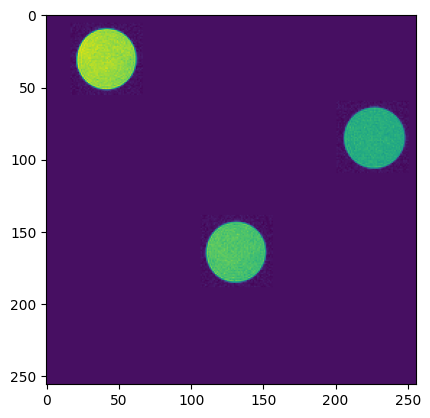

In [38]:
sys.setrecursionlimit(10000)
limit = sys.getrecursionlimit()
rearranged_images = rearrange_image_samples(cropped_array, avg_bg_list)
plt.imshow(rearranged_images[3])


In [39]:
print(additional_features_array_t1[0], additional_features_array_t2[0])

[  5.00850954 110.72806272] [  5.00850954 100.        ]


In [40]:
shift_angle = np.pi / 4.4
shift_angle

0.7139983303613165

In [41]:
def data_augmentation(cropped_array_t1, cropped_array_t2):
    points = np.array([(35, 125), (56, 63), (114, 24), (181, 31), (236, 99), (232, 165), (184, 211)])
    IMAGE_SIZE = (300, 300)
    all_image_arrays_t1 = []
    all_image_arrays_t2 = []
    all_image_arrays_mixed = []
    all_shifted_points_list = []
    all_images_array_c1=np.empty((0, 300, 300))
    all_images_array_c2=np.empty((0, 300, 300))
    all_features_array=np.empty((0, 4))
    unique_shifted_points=[]
    # Fit an ellipse to the points
    ellipse_params = fit_ellipse(points)
    
    # Shift points along the ellipse
    for shifts in np.arange(1, 8, 0.05):
        image_array = np.full(IMAGE_SIZE, avg_bg_list[0])
        shift_angle = np.pi / shifts  # shift by 1/range of the full circle
        shifted_points = shift_points_on_ellipse(points, ellipse_params, shift_angle)
        shifted_points = shifted_points.astype(int)
        if not any(np.array_equal(shifted_points[0, 0], existing_array) for existing_array in unique_shifted_points):
            unique_shifted_points.append(shifted_points[0, 0])
            #all_image_arrays_t1 = fill_empty_img(image_array, cropped_array_t1, all_image_arrays_t1, shifted_points_int)
            #all_image_arrays_t2=fill_empty_img(image_array, cropped_array_t2[1], all_image_arrays_t2, shifted_points_int)
            #all_image_arrays_mixed = fill_empty_img(image_array, cropped_array_mixed, all_image_arrays_mixed, shifted_points_int)
        
            all_image_arrays_t1, shifted_points = fill_empty_img(image_array, cropped_array_t1, [], shifted_points, (300, 300))
            all_image_arrays_t2, shifted_points = fill_empty_img(image_array, cropped_array_t2, [], shifted_points, (300, 300))
            all_image_arrays_t1, all_image_arrays_t2, all_features, shifted_points_list = prepare_for_pairing(all_image_arrays_t1, all_image_arrays_t2, additional_features_array_t1, additional_features_array_t2, shifted_points)
            if len(all_images_array_c1) < 16000:
                all_images_array_c1 = np.concatenate((all_images_array_c1, all_image_arrays_t1))
                all_images_array_c2 = np.concatenate((all_images_array_c2, all_image_arrays_t2))
                all_features_array = np.concatenate((all_features_array, all_features))
                all_shifted_points_list.extend(shifted_points_list)
            else:
                pass
        else:
            continue
    return all_images_array_c1, all_images_array_c2, all_features_array, all_shifted_points_list

In [42]:
if (exists('image_arrays1.npz')) == False:
    print("create array")
    all_images_array_c1, all_images_array_c2, all_features_array, all_shifted_points_list=data_augmentation(cropped_array_t1, cropped_array_t2)
    np.savez('image_arrays1.npz', arr_c1=all_images_array_c1, arr_c2=all_images_array_c2, arr_feat=all_features_array, shi_poi=all_shifted_points_list)
else:
    print("load array")
    image_arrays = np.load('image_arrays.npz')
    all_images_array_c1 = image_arrays['arr_c1'] 
    all_images_array_c2 = image_arrays['arr_c2']
    all_features_array = image_arrays['arr_feat']
    all_shifted_points_list = image_arrays['shi_poi']

create array


In [43]:
all_images_array_c1=np.expand_dims(all_images_array_c1, axis=-3)
all_images_array_c2=np.expand_dims(all_images_array_c2, axis=-3)

print(all_images_array_c1.shape)
print(all_images_array_c2.shape)
print(all_features_array.shape)

(16632, 1, 300, 300)
(16632, 1, 300, 300)
(16632, 4)


In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Let's say your data is in a list of arrays called data
# For example: data = [np.array([[1, 2], [3, 4], ...]), np.array([[5, 6], [7, 8], ...]), ...]

# Extract the first value of each list in each array
#first_values = [arr[0, 0] for arr in all_shifted_points_list]

# Create a histogram of the first values
#plt.hist(first_values, bins='auto')  # You can specify the number of bins or let matplotlib decide with 'auto'

#plt.title('Distribution of first values')
#plt.xlabel('Value')
#plt.ylabel('Frequency')

#plt.show()

In [45]:
from collections import Counter

#first_values_count = Counter(first_values)

# To print the count of each unique value for the shifted points
#for value, count in first_values_count.items():
    #print(f"Value {value} occurs {count} times")

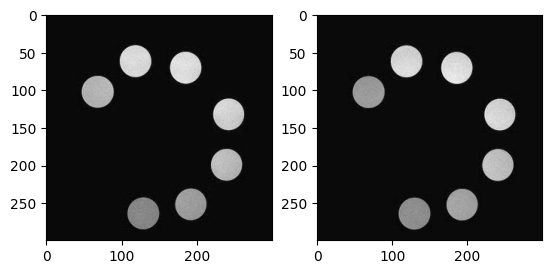

In [46]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(all_images_array_c1[1000].squeeze(), cmap="gray")
f.add_subplot(1,2, 2)
plt.imshow(all_images_array_c2[1000].squeeze(), cmap="gray")
plt.show(block=True)

In [47]:
'''def sample_reassembling(points, image_size, shift_range, *args):
    cropped_arrays = []
    image_arrays = []
    additional_features_arrays = []
    additional_features_arrays_of_shift = []
    for arrays in range(0, len(args)):
        cropped_arrays.append(args[arrays][0])
        image_arrays.append(args[arrays][1])
        additional_features_arrays.append(args[arrays][2])
        additional_features_arrays_of_shift.append(args[arrays][3])
    IMAGE_SIZE = image_size
    # Fit an ellipse to the points
    ellipse_params = fit_ellipse(points)
    # Shift points along the ellipse
    for shifts in range(1, shift_range):
        image_array = np.full(IMAGE_SIZE, avg_bg_list[0])
        shift_angle = np.pi / shifts  # shift by 1/range of the full circle
        shifted_points = shift_points_on_ellipse(points, ellipse_params, shift_angle)
        shifted_points_int = shifted_points.astype(int)

        for cr_arr, (img_index, img_arr) in zip(cropped_arrays, enumerate(image_arrays)):
            image_arrays[img_index] = fill_empty_img(image_array, cr_arr, img_arr, shifted_points_int)
            additional_features_arrays_of_shift[img_index].extend(additional_features_arrays[img_index])

    return image_arrays, additional_features_arrays_of_shift
'''

'def sample_reassembling(points, image_size, shift_range, *args):\n    cropped_arrays = []\n    image_arrays = []\n    additional_features_arrays = []\n    additional_features_arrays_of_shift = []\n    for arrays in range(0, len(args)):\n        cropped_arrays.append(args[arrays][0])\n        image_arrays.append(args[arrays][1])\n        additional_features_arrays.append(args[arrays][2])\n        additional_features_arrays_of_shift.append(args[arrays][3])\n    IMAGE_SIZE = image_size\n    # Fit an ellipse to the points\n    ellipse_params = fit_ellipse(points)\n    # Shift points along the ellipse\n    for shifts in range(1, shift_range):\n        image_array = np.full(IMAGE_SIZE, avg_bg_list[0])\n        shift_angle = np.pi / shifts  # shift by 1/range of the full circle\n        shifted_points = shift_points_on_ellipse(points, ellipse_params, shift_angle)\n        shifted_points_int = shifted_points.astype(int)\n\n        for cr_arr, (img_index, img_arr) in zip(cropped_arrays, enumer

In [48]:
'''images, features = sample_reassembling(
    np.array([(35, 125), (56, 63), (114, 24), (181, 31), (236, 99), (232, 165), (184, 211)]),
    (300, 300),
    20,
    (cropped_array_t1, [], additional_features_array_t1, []),
    (cropped_array_mixed, [], additional_features_array_mixed, [])
    # (cropped_array_t1, []),
    # (cropped_array_mixed, [])
)'''

'images, features = sample_reassembling(\n    np.array([(35, 125), (56, 63), (114, 24), (181, 31), (236, 99), (232, 165), (184, 211)]),\n    (300, 300),\n    20,\n    (cropped_array_t1, [], additional_features_array_t1, []),\n    (cropped_array_mixed, [], additional_features_array_mixed, [])\n    # (cropped_array_t1, []),\n    # (cropped_array_mixed, [])\n)'

In [49]:
'''def get_sample_batches_per_image_for_plotting(sample_lists, batch_size, starting_position):
    batch_list = []
    for sample in sample_lists:
        all_images = []
        for image in sample:
            all_images.append(
        elements = list[starting_position : starting_position + batch_size]
        for element in elements:
            all_images = 0
            if isinstance(element, np.ndarray):
                all_images += np.average(element)
            else:
                all_images += element
        batch_list.append(all_images / batch_size)
    return batch_list
'''

'def get_sample_batches_per_image_for_plotting(sample_lists, batch_size, starting_position):\n    batch_list = []\n    for sample in sample_lists:\n        all_images = []\n        for image in sample:\n            all_images.append(\n        elements = list[starting_position : starting_position + batch_size]\n        for element in elements:\n            all_images = 0\n            if isinstance(element, np.ndarray):\n                all_images += np.average(element)\n            else:\n                all_images += element\n        batch_list.append(all_images / batch_size)\n    return batch_list\n'

In [50]:
'''def prepare_for_plotting(sample_lists, column_name):
    BATCH_SIZE = 10
    starting_position = 0
    all_batches = []
    all_features = []
    for num in range(0, len(df_cuso)):
        batch = get_sample_batches_per_image_for_plotting(
            [
                sample_lists[0],
                sample_lists[1],
                sample_lists[2],
                sample_lists[3],
                sample_lists[4],
                sample_lists[5],
                sample_lists[6],
            ],
            BATCH_SIZE,
            starting_position,
        )
        all_batches.append(batch)
        all_features.append([df_cuso[column_name][num]] * 7)
        starting_position += 10
    return all_batches, all_features'''

'def prepare_for_plotting(sample_lists, column_name):\n    BATCH_SIZE = 10\n    starting_position = 0\n    all_batches = []\n    all_features = []\n    for num in range(0, len(df_cuso)):\n        batch = get_sample_batches_per_image_for_plotting(\n            [\n                sample_lists[0],\n                sample_lists[1],\n                sample_lists[2],\n                sample_lists[3],\n                sample_lists[4],\n                sample_lists[5],\n                sample_lists[6],\n            ],\n            BATCH_SIZE,\n            starting_position,\n        )\n        all_batches.append(batch)\n        all_features.append([df_cuso[column_name][num]] * 7)\n        starting_position += 10\n    return all_batches, all_features'

In [51]:
transposed_array = additional_features_array.T

# Convert each row of the transposed array into a list and add it to a list
list_of_columns = [row.tolist() for row in transposed_array]
te_values=list_of_columns[0]
tr_values=list_of_columns[1]

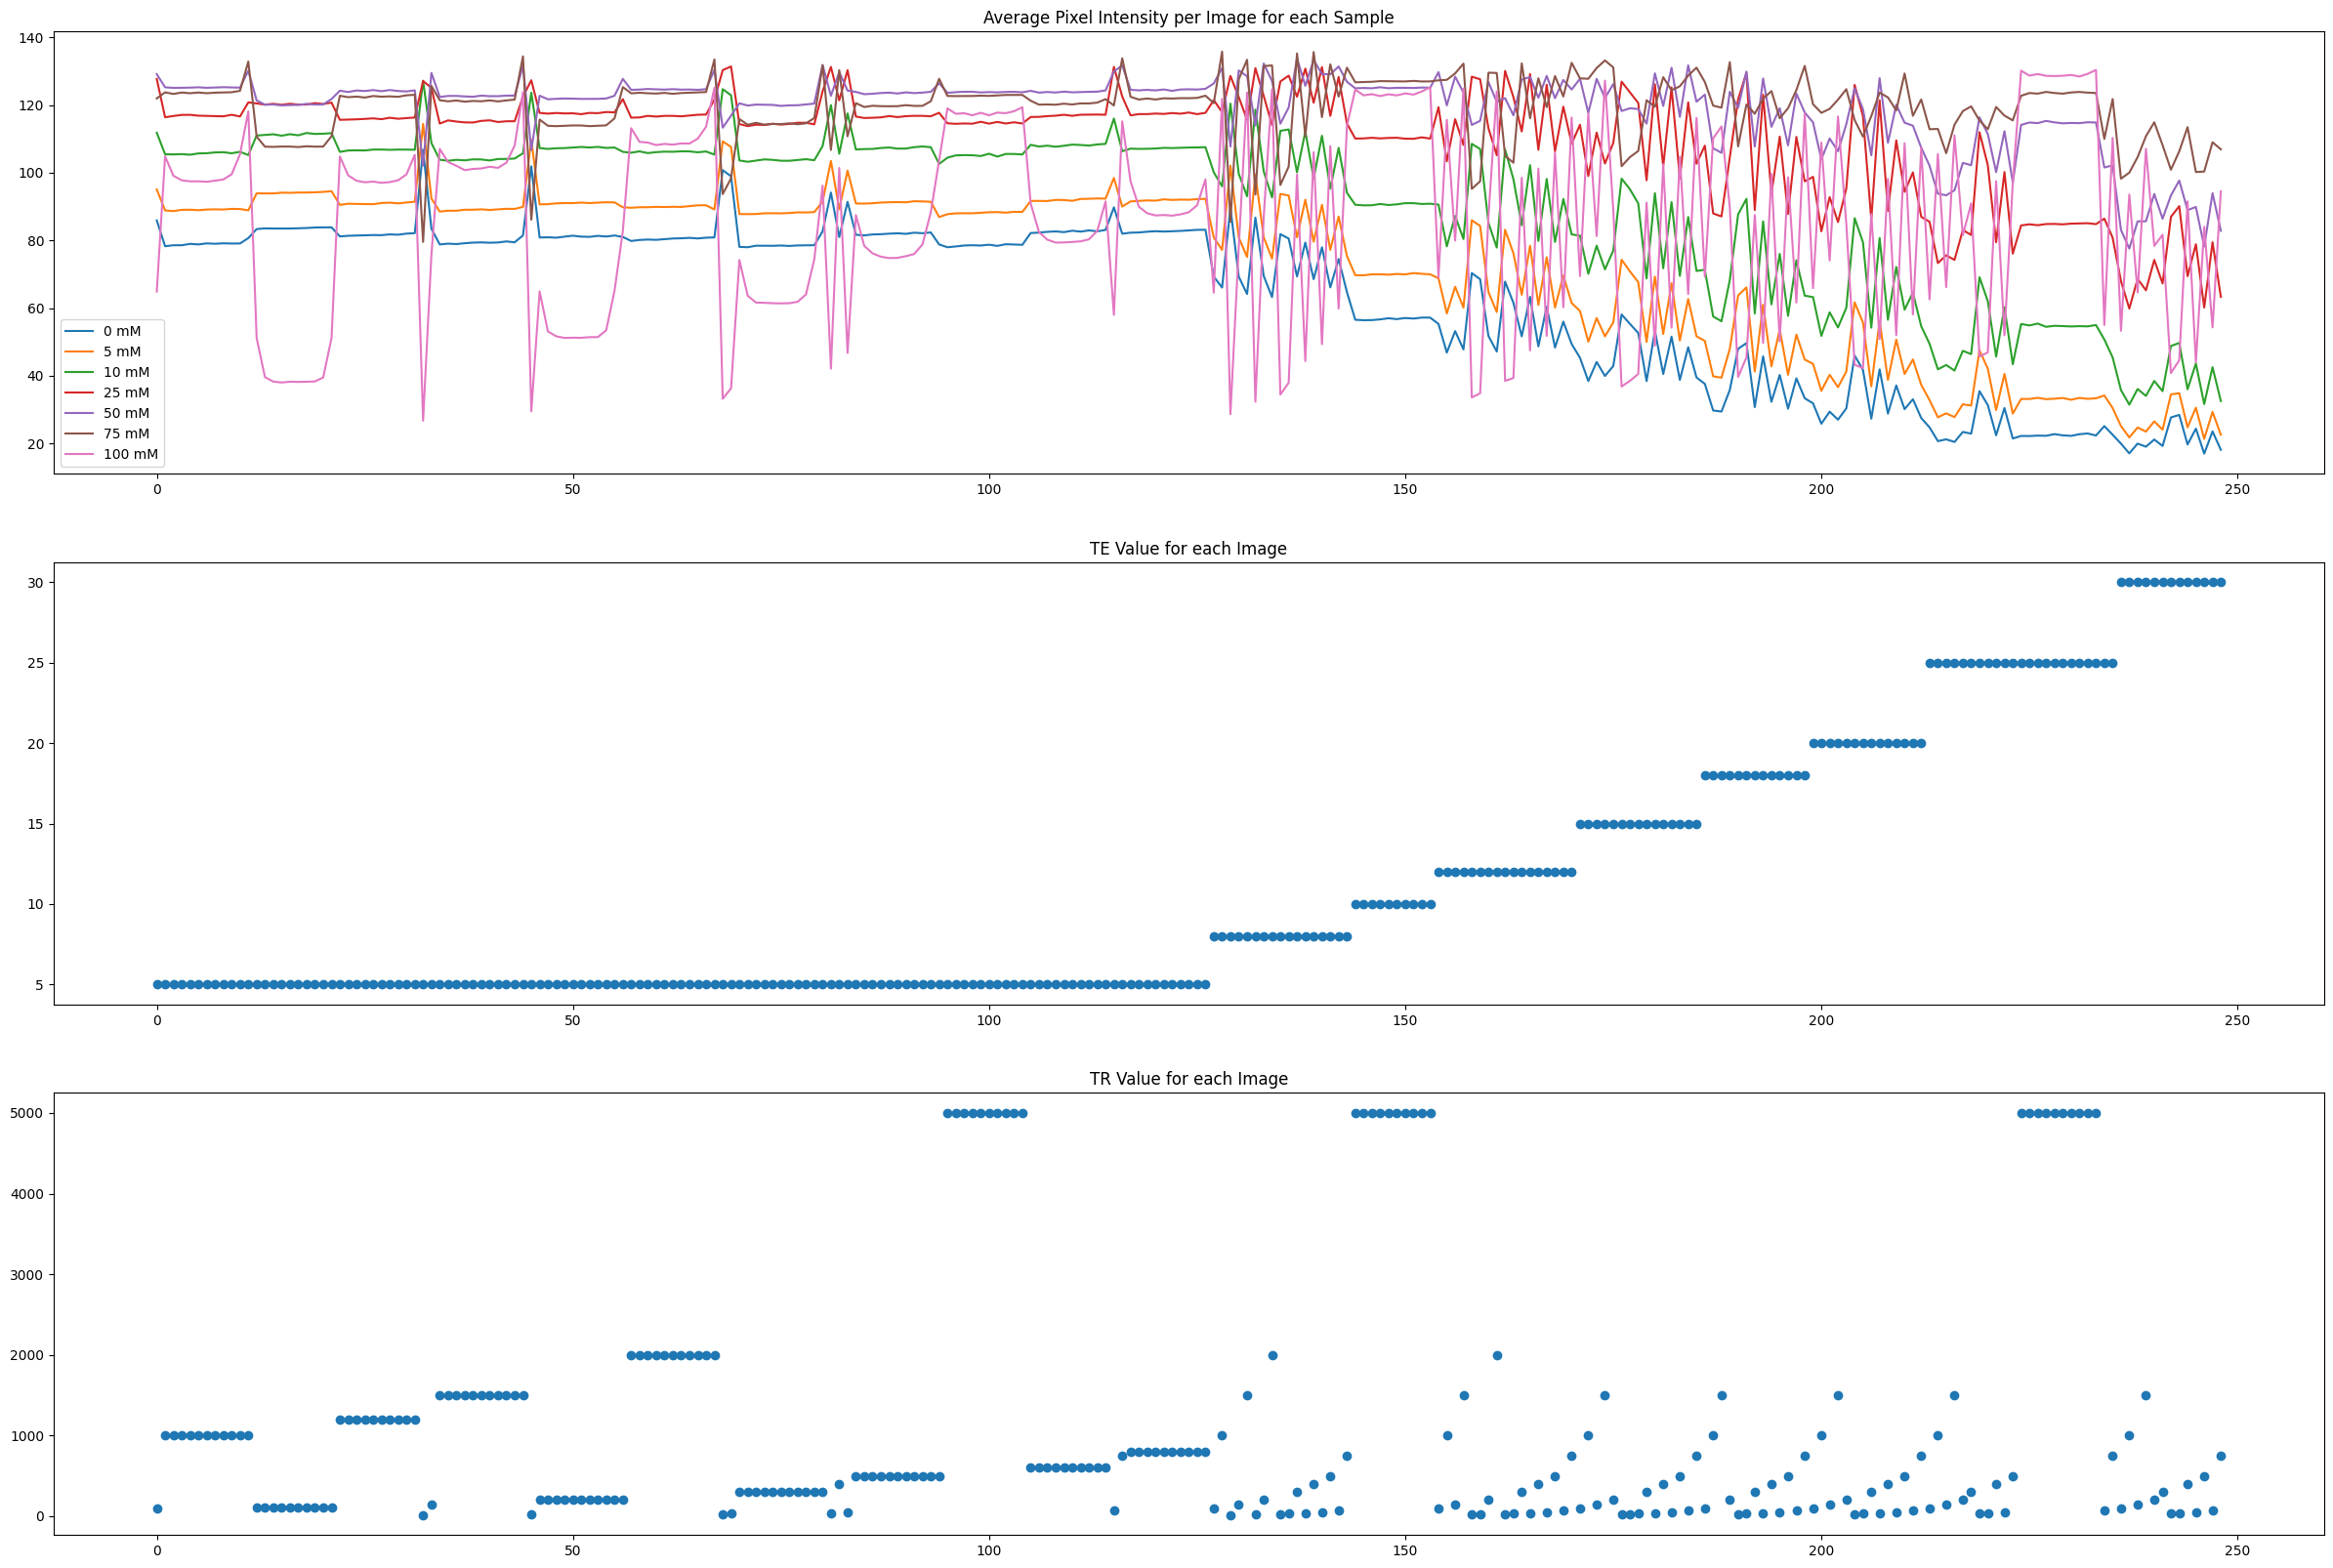

In [52]:
sample_names=[0, 5, 10, 25, 50, 75, 100]
avg_pixel_values = []
for images in [sample1_list, sample2_list, sample3_list, sample4_list, sample5_list, sample6_list, sample7_list]:
    avg_pixel_values.append([np.mean(array) for array in images])
    
fig, axs = plt.subplots(3, figsize=(30, 20))

for index, sample_average in enumerate(avg_pixel_values):
    axs[0].plot(sample_average, label=f'{sample_names[index]} mM')
    

axs[1].scatter(list(range(len(te_values))), te_values)
axs[2].scatter(list(range(len(tr_values))), tr_values)

axs[0].legend()
axs[0].set_title('Average Pixel Intensity per Image for each Sample')
axs[1].set_title('TE Value for each Image')
axs[2].set_title('TR Value for each Image')

plt.show()

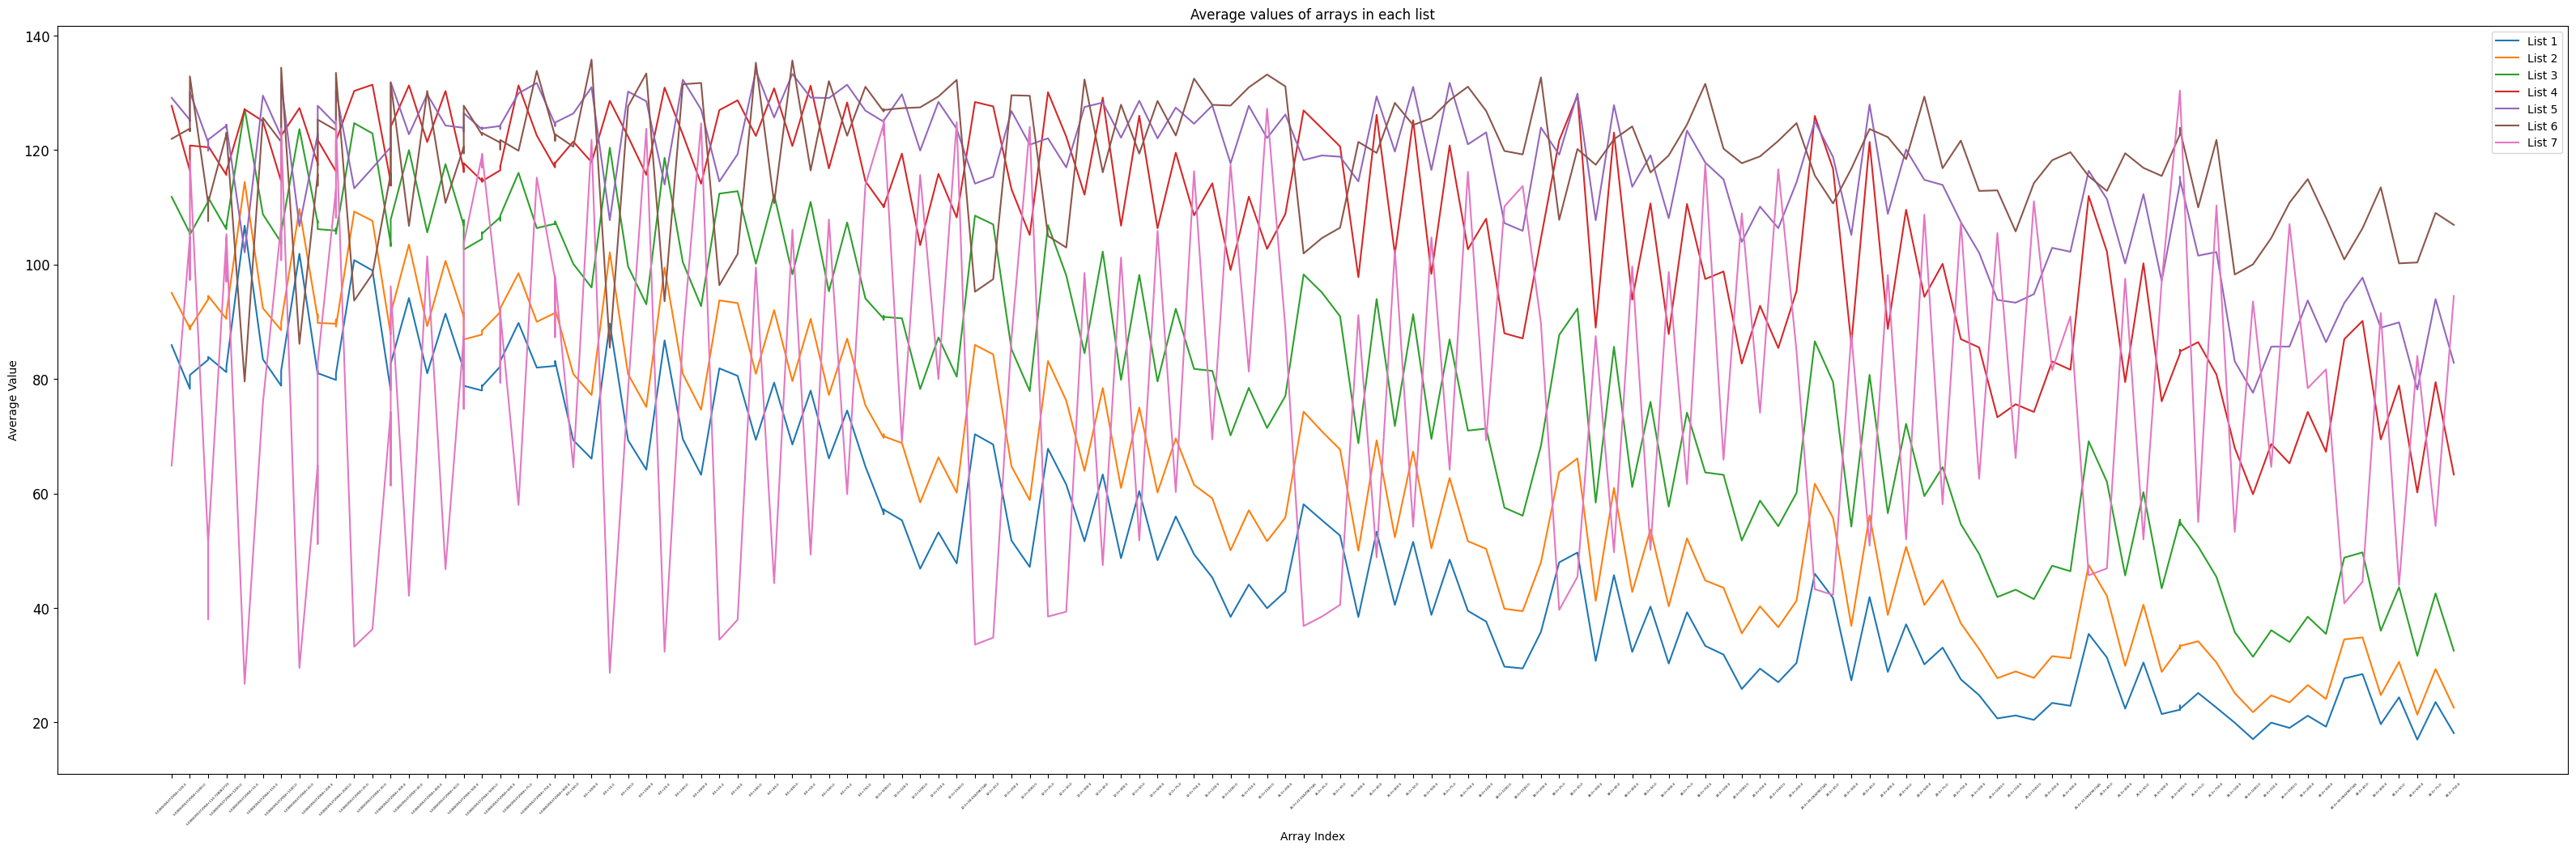

In [53]:
avg_pixel_values = []
xticks_labels = [f"{a}+{b}" for a, b in zip(te_values, tr_values)]
for images in [sample1_list, sample2_list, sample3_list, sample4_list, sample5_list, sample6_list, sample7_list]:
    avg_pixel_values.append([np.mean(array) for array in images])
    
plt.figure(figsize=(40, 12))

# Generate a line plot for each list of averages
for index, sample_average in enumerate(avg_pixel_values):
    plt.plot(xticks_labels, sample_average, label=f'List {index+1}')
    
plt.xticks(rotation = 45, fontsize=3)
plt.yticks(fontsize=12)
plt.title('Average values of arrays in each list')
plt.xlabel('Array Index')
plt.ylabel('Average Value')

# Add a legend to explain which line corresponds to which list
plt.legend()


#plt.xticks(ticks=range(len(my_xticks)), labels=my_xticks, rotation=45)

# Show the plot
plt.show()

In [54]:
'''all_batches, all_features = prepare_for_plotting(
    [sample1_list, sample2_list, sample3_list, sample4_list, sample5_list, sample6_list, sample7_list], "repetitionTime"
)
'''

'all_batches, all_features = prepare_for_plotting(\n    [sample1_list, sample2_list, sample3_list, sample4_list, sample5_list, sample6_list, sample7_list], "repetitionTime"\n)\n'

In [55]:
'''def align_images(batches):
    images = 0
    all_images_batches = []
    while True:
        try:
            images_batch = []
            for i in batches:
                images_batch.append(i[images])
            all_images_batches.append(images_batch)
            images += 1
        except:
            break
    return all_images_batches
'''

'def align_images(batches):\n    images = 0\n    all_images_batches = []\n    while True:\n        try:\n            images_batch = []\n            for i in batches:\n                images_batch.append(i[images])\n            all_images_batches.append(images_batch)\n            images += 1\n        except:\n            break\n    return all_images_batches\n'

In [56]:
#all_images_batches = align_images(all_batches)


In [57]:
'''all_features = []

for index, row in df_cuso_sorted.iterrows():
    combined_value = (
        str(row['repetitionTime']) + ' + ' + str(row['effectiveEchoTime']) + '\n' + '(' + str(row['fileName']) + ')'
    )
    all_features.append(combined_value)
'''

"all_features = []\n\nfor index, row in df_cuso_sorted.iterrows():\n    combined_value = (\n        str(row['repetitionTime']) + ' + ' + str(row['effectiveEchoTime']) + '\n' + '(' + str(row['fileName']) + ')'\n    )\n    all_features.append(combined_value)\n"

In [58]:
'''conc = [100, 80, 60, 40, 20, 10, 0]
plt.figure(figsize=(20, 10))
for batches in all_images_batches:
    plt.plot(list(range(len(df_cuso_sorted["repetitionTime"]))), batches, label=f'CuSO4:{conc[0]}')
    del conc[0]
    plt.xticks(list(range(len(df_cuso_sorted["repetitionTime"]))), all_features)
plt.xticks(rotation=45)
plt.xlabel('Sequence Parameters')
plt.ylabel('Avg. Pixel Intensity')
plt.title('Samples Without Artefacts')
plt.legend()
plt.show()

### With increasing TR and low TE, the intensity of each sample is just marginally affected, except for water which leads to an increasing intendity.
### Increasing the TE at max TR leads to a drop in intensity, also for water, which then recovers again with further increasing TE. TR seems to have an overall small effect on the intensity,
### whereas the TE has its optimum at small values, leading to the conclusion that the contrast of the images is primarily dominated by the T1 weight, which is enhanced using small TE and small TR.
### With increasing TR values, the images might rather be dominated by the PD contrast, but the exact border is hard to determine. After the big drop, the increase in intensity might point out the
### enhancement of T2 weighted contrast, which contributions are similar between all samples, making it inapropriate for sample comparison. Also, the intensities for all samples are weaker compared to
### presumably T1 and PD weighted images. However, the big drop is difficult to explain, as one wouldn't expect that few intensities when they are larger using smaller and higher TEs and the same TR. Only
### with short TE and TR the intensity should be vers weak, which is not part of the measurment protocol. For the presumable T1 and PD weighted images, the intensities are closer together when it comes to low
### concentrations of CuSO4, making them less well discernable in terms of contrast. For the images of the right part, they are not discernable at all.
'''

'conc = [100, 80, 60, 40, 20, 10, 0]\nplt.figure(figsize=(20, 10))\nfor batches in all_images_batches:\n    plt.plot(list(range(len(df_cuso_sorted["repetitionTime"]))), batches, label=f\'CuSO4:{conc[0]}\')\n    del conc[0]\n    plt.xticks(list(range(len(df_cuso_sorted["repetitionTime"]))), all_features)\nplt.xticks(rotation=45)\nplt.xlabel(\'Sequence Parameters\')\nplt.ylabel(\'Avg. Pixel Intensity\')\nplt.title(\'Samples Without Artefacts\')\nplt.legend()\nplt.show()\n\n### With increasing TR and low TE, the intensity of each sample is just marginally affected, except for water which leads to an increasing intendity.\n### Increasing the TE at max TR leads to a drop in intensity, also for water, which then recovers again with further increasing TE. TR seems to have an overall small effect on the intensity,\n### whereas the TE has its optimum at small values, leading to the conclusion that the contrast of the images is primarily dominated by the T1 weight, which is enhanced using small 

In [59]:
#(image_array, additional_features_array) = extract_samples_from_images(df_cuso_sorted, cropping=False)


In [60]:
#additional_features_array.shape


In [61]:
#image_array.shape


In [62]:
'''def separate_images_by_contrast(te_limit, tr_limit, image_array, additional_features_array):
    ### Only those images are selected for one of the contrasts that comply t the conitions for TE and TR. In case any images were not measured with a SP falling into the range of the TE and TR limits, they are not assigned to one of
    ### the contrast datasets.
    condition1 = additional_features_array[..., 0] <= te_limit
    condition2 = additional_features_array[..., 1] <= tr_limit
    combined_condition = condition1 & condition2
    combined_condition_flat = combined_condition.flatten()
    # combined_condition_reshaped = combined_condition.reshape(-1, 1, 1)
    selected_indices = np.where(combined_condition)[0]
    # broadcasted_condition = np.broadcast_to(combined_condition_reshaped, image_array.shape)
    additional_features_array_c1 = np.compress(combined_condition_flat, additional_features_array, axis=0)
    image_array_c1 = image_array[selected_indices]
    additional_features_array_c2 = np.compress(~combined_condition_flat, additional_features_array, axis=0)
    image_array_c2 = np.delete(image_array, selected_indices, axis=0)
    # Use boolean indexing to create the new arrays
    c1_image_set = np.array()
    c2_image_set = np.array()
    for im, feature in zip(image_array, additional_features_array):
        te = feature[0][0]
        tr = feature[0][1]
        if (te <= te_limit) and (tr <= tr_limit):
            c1_image_set.append(im)
        else:
            c2_image_set.append(im)
    return c1_image_set, c2_image_set
    return additional_features_array_c1, image_array_c1, additional_features_array_c2, image_array_c2
    # return image_array_c1, image_array_c2
'''

'def separate_images_by_contrast(te_limit, tr_limit, image_array, additional_features_array):\n    ### Only those images are selected for one of the contrasts that comply t the conitions for TE and TR. In case any images were not measured with a SP falling into the range of the TE and TR limits, they are not assigned to one of\n    ### the contrast datasets.\n    condition1 = additional_features_array[..., 0] <= te_limit\n    condition2 = additional_features_array[..., 1] <= tr_limit\n    combined_condition = condition1 & condition2\n    combined_condition_flat = combined_condition.flatten()\n    # combined_condition_reshaped = combined_condition.reshape(-1, 1, 1)\n    selected_indices = np.where(combined_condition)[0]\n    # broadcasted_condition = np.broadcast_to(combined_condition_reshaped, image_array.shape)\n    additional_features_array_c1 = np.compress(combined_condition_flat, additional_features_array, axis=0)\n    image_array_c1 = image_array[selected_indices]\n    additional_

In [63]:
'''additional_features_array_c1, c1_image_set, additional_features_array_c2, c2_image_set = separate_images_by_contrast(
    6, 2000, image_array, additional_features_array
)
'''

'additional_features_array_c1, c1_image_set, additional_features_array_c2, c2_image_set = separate_images_by_contrast(\n    6, 2000, image_array, additional_features_array\n)\n'

In [64]:
#image_array.shape

In [65]:
'''print(additional_features_array_c1.shape)
print(c1_image_set.shape)
print(additional_features_array_c2.shape)
print(c2_image_set.shape)'''

'print(additional_features_array_c1.shape)\nprint(c1_image_set.shape)\nprint(additional_features_array_c2.shape)\nprint(c2_image_set.shape)'

In [66]:
### align image arrays for testing purposes
#all_image_arrays_mixed_cut = all_image_arrays_mixed[: all_image_arrays_t1.shape[0]]
#all_feature_arrays_mixed_cut = all_feature_features_mixed[: all_feature_features_t1.shape[0]]
#all_image_arrays_mixed_cut.shape
#all_feature_arrays_mixed_cut.shape


In [67]:
#c2_image_set.shape

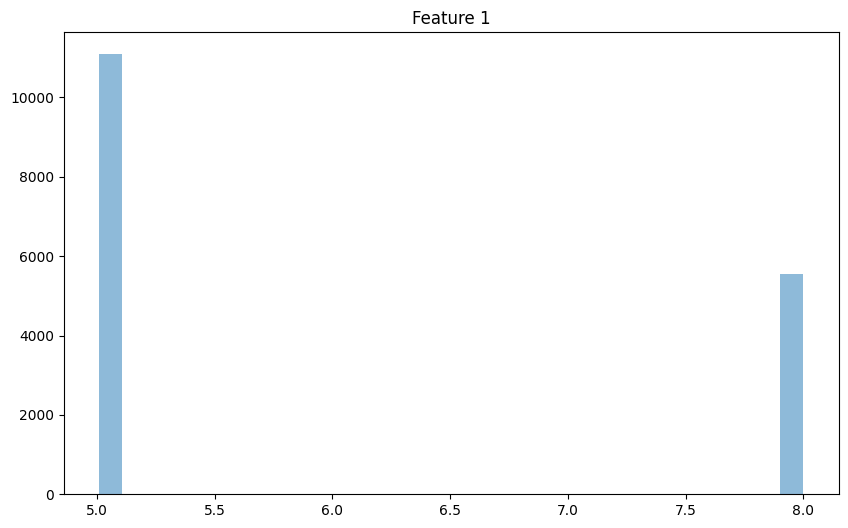

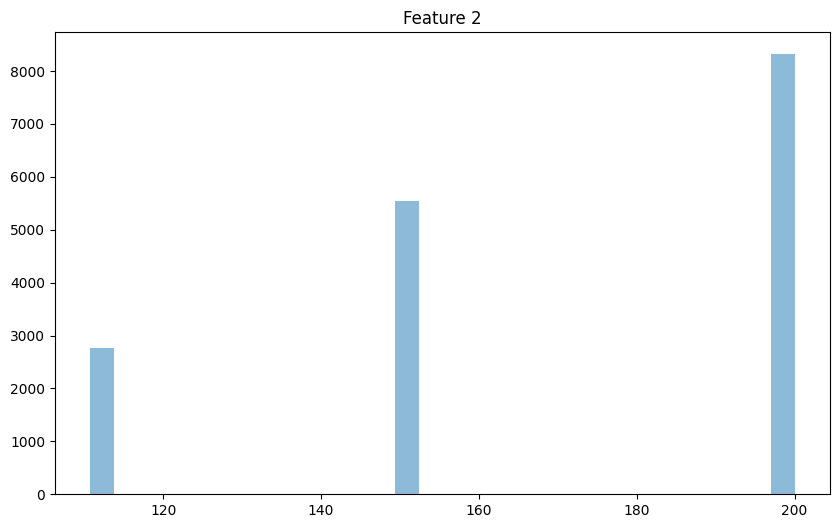

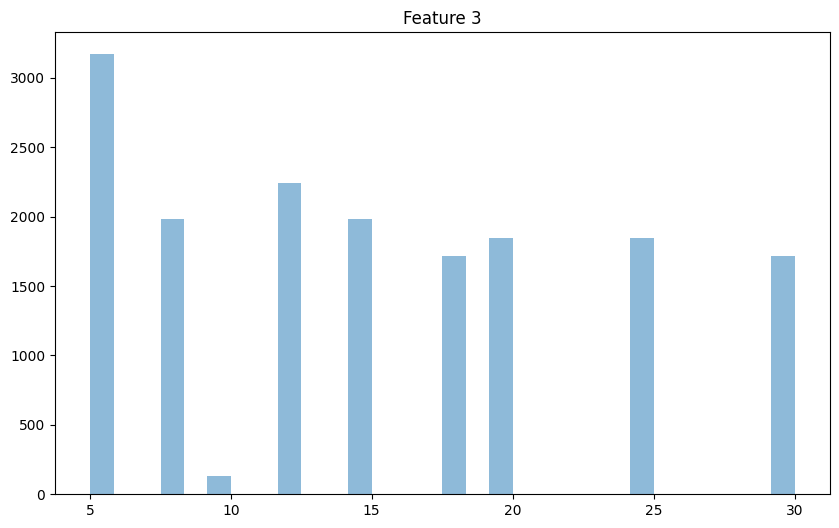

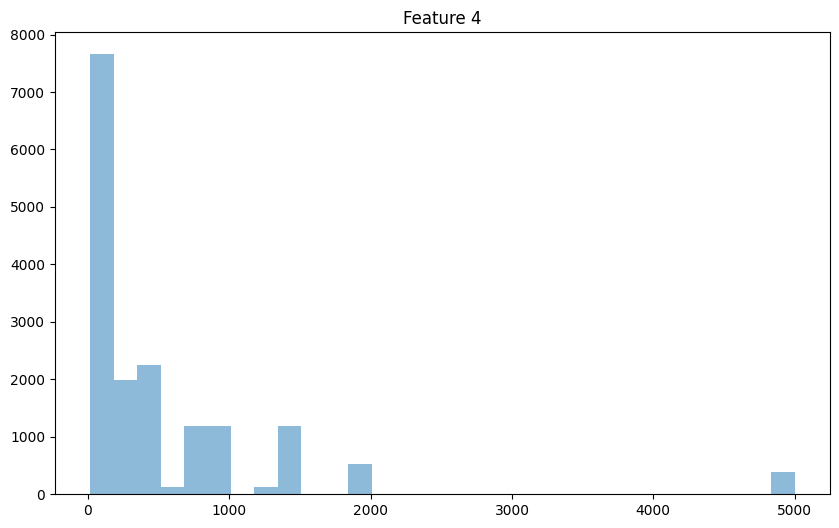

In [68]:
# Assume 'features' is your numpy array with shape (1000, 4)
for i in range(all_features_array.shape[1]):  # for each feature
    plt.figure(figsize=(10, 6))
    plt.hist(all_features_array[:, i], bins=30, alpha=0.5)
    plt.title(f'Feature {i+1}')
    plt.show()

In [69]:
'''X_temp, X_test, y_temp, y_test, feat_temp, feat_test, shifted_points_temp, shifted_points_test = train_test_split(
    all_images_array_c1,
    all_features_array,
    all_images_array_c2,
    all_shifted_points_list,
    test_size=0.2,
    stratify=all_features_array,
    random_state=42
)
X_train, X_val, y_train, y_val, feat_train, feat_val, shifted_points_train, shifted_points_val = train_test_split(X_temp, y_temp, feat_temp, shifted_points_temp, test_size=0.25, stratify=feat_temp, random_state=42)'''

'X_temp, X_test, y_temp, y_test, feat_temp, feat_test, shifted_points_temp, shifted_points_test = train_test_split(\n    all_images_array_c1,\n    all_features_array,\n    all_images_array_c2,\n    all_shifted_points_list,\n    test_size=0.2,\n    stratify=all_features_array,\n    random_state=42\n)\nX_train, X_val, y_train, y_val, feat_train, feat_val, shifted_points_train, shifted_points_val = train_test_split(X_temp, y_temp, feat_temp, shifted_points_temp, test_size=0.25, stratify=feat_temp, random_state=42)'

In [70]:
X_temp, X_test, y_temp, y_test, feat_temp, feat_test, shifted_points_temp, shifted_points_test = train_test_split(all_images_array_c1, all_images_array_c2, all_features_array, all_shifted_points_list, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val, feat_train, feat_val, shifted_points_train, shifted_points_val = train_test_split(X_temp, y_temp, feat_temp, shifted_points_temp, test_size=0.25, random_state=42)

In [71]:
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('X_test.npy', X_test)

np.save('feat_train.npy', feat_train)
np.save('feat_val.npy', feat_val)
np.save('feat_test.npy', feat_test)

np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)

np.save('shifted_points_train.npy', shifted_points_train)
np.save('shifted_points_val.npy', shifted_points_val)
np.save('shifted_points_test.npy', shifted_points_test)